In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import os

In [2]:
def union(a, b):
    y_idx, x_idx = np.where(b == 1)
    a_ret = copy.deepcopy(a)
    for y, x in zip(y_idx, x_idx):
        a_ret[y, x] = 1
    return a_ret

def exclusion(a, b):
    y_idx, x_idx = np.where(b == 1)
    a_ret = copy.deepcopy(a)
    for y, x in zip(y_idx, x_idx):
        a_ret[y, x] = 0
    return a_ret

In [3]:
class structuring_element:
    def __init__(self, w, h, center_x, center_y):
        self.w = w
        self.h = h
        self.cx = center_x
        self.cy = center_y
        self.kernel = np.zeros((h, w))
        
    def is_kernel_out_of_bound(self, coord_x, coord_y, img_w, img_h):
        return (coord_x - self.cx < 0 or coord_y - self.cy < 0 or coord_x + (self.w - self.cx - 1) >= img_w or coord_y + (self.h - self.cy - 1) >= img_h)
    
    # return True if a hit is calculated
    def hit_and_miss(self, block):
        for idx_i in range(self.w):
            for idx_j in range(self.h):
                if self.kernel[idx_j, idx_i] < 0:
                    continue
                diff = block[idx_j, idx_i] - self.kernel[idx_j, idx_i]
                if diff != 0:
                    return False
        return True
    
    # return True if the reference point can be eroded
    def erosion(self, block, use_foreground=True):
        for idx_i in range(self.w):
            for idx_j in range(self.h):
                if self.kernel[idx_j, idx_i] < 0:
                    continue
                if use_foreground:
                    if (self.kernel[idx_j, idx_i] == 1) and (block[idx_j, idx_i] == 0):
                        if block[self.cy, self.cx] == 1:
                            return True
                else:
                    if (self.kernel[idx_j, idx_i] == 0) and (block[idx_j, idx_i] == 0):
                        if block[self.cy, self.cx] == 1:
                            return True
        return False
    
    # return True if the reference point can be dilated
    def dilation(self, block, use_foreground=True):
        for idx_i in range(self.w):
            for idx_j in range(self.h):
                if self.kernel[idx_j, idx_i] < 0:
                    continue
                if use_foreground:
                    if (self.kernel[idx_j, idx_i] == 1) and (block[idx_j, idx_i] == 1):
                        if block[self.cy, self.cx] == 0:
                            return True
                else:
                    if (self.kernel[idx_j, idx_i] == 0) and (block[idx_j, idx_i] == 1):
                        if block[self.cy, self.cx] == 0:
                            return True
        return False

    def rotate_kernel_90_degrees(self):
        self.kernel = np.rot90(self.kernel)

In [4]:
def hit_and_miss(binary, st):
    height, width = binary.shape
    ret = np.zeros((height, width))
    cnt = 0
    for idx_x in range(width):
        for idx_y in range(height):
            if not st.is_kernel_out_of_bound(idx_x, idx_y, width, height):
                block = binary[idx_y-st.cy:idx_y+(st.h-st.cy), idx_x-st.cx:idx_x+(st.w-st.cx)]
                if st.hit_and_miss(block):
                    ret[idx_y, idx_x] = 1
    return ret.astype('uint8')

In [5]:
def erosion_golay(binary, st, golay_use_foreground=True):
    height, width = binary.shape
    ret = np.zeros((height, width))
    cnt = 0
    for idx_x in range(width):
        for idx_y in range(height):
            if not st.is_kernel_out_of_bound(idx_x, idx_y, width, height):
                block = binary[idx_y-st.cy:idx_y+(st.h-st.cy), idx_x-st.cx:idx_x+(st.w-st.cx)]
                if st.erosion(block, golay_use_foreground):
                    ret[idx_y, idx_x] = 1
    return ret.astype('uint8')

def dilation_golay(binary, st, golay_use_foreground=True):
    height, width = binary.shape
    ret = np.zeros((height, width))
    cnt = 0
    for idx_x in range(width):
        for idx_y in range(height):
            if not st.is_kernel_out_of_bound(idx_x, idx_y, width, height):
                block = binary[idx_y-st.cy:idx_y+(st.h-st.cy), idx_x-st.cx:idx_x+(st.w-st.cx)]
                if st.dilation(block, golay_use_foreground):
                    ret[idx_y, idx_x] = 1
    return ret.astype('uint8')

def erosion(binary, golay_alphabet):
    sts = golay_elements(golay_alphabet)
    for s in sts:
        ret = erosion_golay(binary, s)
        binary = exclusion(binary, ret)
    return binary

def dilation(binary, golay_alphabet):
    sts = golay_elements(golay_alphabet)
    for s in sts:
        ret = dilation_golay(binary, s)
        binary = union(binary, ret)
    return binary

In [6]:
# sequential rotation hit_and_miss operation of a structuring element
def hit_and_miss_rot(binary, st):
    ret = hit_and_miss(binary, st)
    for i in range(3):
        st.kernel = np.rot90(st.kernel)
        ret += hit_and_miss(binary, st)
    return ret

In [7]:
def golay_elements(GolayElement):
    if GolayElement == 'h':
        h1 = structuring_element(3, 3, 1, 1)
        h1.kernel = np.ones((3, 3))
        H = [h1]
        return H
    elif GolayElement == 'i':
        i1 = structuring_element(3, 3, 1, 1)
        i1.kernel = np.zeros((3, 3))
        I = [i1]
        return I
    elif GolayElement == 'e':
        e1 = structuring_element(3, 3, 1, 1)
        e1.kernel = np.array([[-1, -1, -1], [0, 1, 0], [0, 0, 0]])
        e2 = structuring_element(3, 3, 1, 1)
        e2.kernel = np.rot90(e1.kernel, 3)
        e3 = structuring_element(3, 3, 1, 1)
        e3.kernel = np.rot90(e2.kernel, 3)
        e4 = structuring_element(3, 3, 1, 1)
        e4.kernel = np.rot90(e3.kernel, 3)
        E = [e1, e2, e3, e4]
        return E
    elif GolayElement == 'l':
        l1 = structuring_element(3, 3, 1, 1)
        l1.kernel = np.array([[0, 0, 0], [-1, 1, -1], [1, 1, 1]])
        l2 = structuring_element(5, 5, 2, 2)
        l2.kernel = np.array([[-1, -1, 0, -1, -1], [-1, -1, -1, 0, -1], [1, -1, 1, -1, 0], [-1, 1, -1, -1, -1], [-1, -1, 1, -1, -1]])
        l3 = structuring_element(3, 3, 1, 1)
        l3.kernel = np.rot90(l1.kernel, 3)
        l4 = structuring_element(5, 5, 2, 2)
        l4.kernel = np.rot90(l2.kernel, 3)
        l5 = structuring_element(3, 3, 1, 1)
        l5.kernel = np.rot90(l3.kernel, 3)
        l6 = structuring_element(5, 5, 2, 2)
        l6.kernel = np.rot90(l4.kernel, 3)
        l7 = structuring_element(3, 3, 1, 1)
        l7.kernel = np.rot90(l5.kernel, 3)
        l8 = structuring_element(5, 5, 2, 2)
        l8.kernel = np.rot90(l6.kernel, 3)
        L = [l1, l2, l3, l4, l5, l6, l7, l8]
        return L
    elif GolayElement == 'm':
        m1 = structuring_element(3, 3, 1, 1)
        m1.kernel = np.array([[1, -1, -1], [1, 1, 0], [1, -1, -1]])
        m2 = structuring_element(5, 5, 2, 2)
        m2.kernel = np.array([[-1, -1, 1, -1, -1], [-1, 1, -1, -1, -1], [1, -1, 1, -1, -1], [-1, -1, -1, 0, -1], [-1, -1, -1, -1, -1]])
        m3 = structuring_element(3, 3, 1, 1)
        m3.kernel = np.rot90(m1.kernel, 3)
        m4 = structuring_element(5, 5, 2, 2)
        m4.kernel = np.rot90(m2.kernel, 3)
        m5 = structuring_element(3, 3, 1, 1)
        m5.kernel = np.rot90(m3.kernel, 3)
        m6 = structuring_element(5, 5, 2, 2)
        m6.kernel = np.rot90(m4.kernel, 3)
        m7 = structuring_element(3, 3, 1, 1)
        m7.kernel = np.rot90(m5.kernel, 3)
        m8 = structuring_element(5, 5, 2, 2)
        m8.kernel = np.rot90(m6.kernel, 3)
        M = [m1, m2, m3, m4, m5, m6, m7, m8]
        return M
    elif GolayElement == 'd':
        d1 = structuring_element(3, 3, 1, 1)
        d1.kernel = np.array([[0, -1, -1], [0, 1, 1], [0, -1, -1]])
        d2 = structuring_element(5, 5, 2, 2)
        d2.kernel = np.array([[-1, -1, 0, -1, -1], [-1, 0, -1, -1, -1], [0, -1, 1, -1, -1], [-1, -1, -1, 1, -1], [-1, -1, -1, -1, -1]])
        d3 = structuring_element(3, 3, 1, 1)
        d3.kernel = np.rot90(d1.kernel, 3)
        d4 = structuring_element(5, 5, 2, 2)
        d4.kernel = np.rot90(d2.kernel, 3)
        d5 = structuring_element(3, 3, 1, 1)
        d5.kernel = np.rot90(d3.kernel, 3)
        d6 = structuring_element(5, 5, 2, 2)
        d6.kernel = np.rot90(d4.kernel, 3)
        d7 = structuring_element(3, 3, 1, 1)
        d7.kernel = np.rot90(d5.kernel, 3)
        d8 = structuring_element(5, 5, 2, 2)
        d8.kernel = np.rot90(d6.kernel, 3)
        D = [d1, d2, d3, d4, d5, d6, d7, d8]
        return D
    elif GolayElement == 'f':
        f1 = structuring_element(3, 3, 1, 1)
        f1.kernel = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 0]])
        f2 = structuring_element(5, 5, 2, 2)
        f2.kernel = np.array([[-1, -1, 1, -1, -1], [-1, 0, 1, 0, -1], [1, -1, 1, -1, 0], [-1, 0, -1, 1, -1], [-1, -1, 0, -1, -1]])
        f3 = structuring_element(3, 3, 1, 1)
        f3.kernel = np.rot90(f1.kernel, 3)
        f4 = structuring_element(5, 5, 2, 2)
        f4.kernel = np.rot90(f2.kernel, 3)
        f5 = structuring_element(3, 3, 1, 1)
        f5.kernel = np.rot90(f3.kernel, 3)
        f6 = structuring_element(5, 5, 2, 2)
        f6.kernel = np.rot90(f4.kernel, 3)
        f7 = structuring_element(3, 3, 1, 1)
        f7.kernel = np.rot90(f5.kernel, 3)
        f8 = structuring_element(5, 5, 2, 2)
        f8.kernel = np.rot90(f6.kernel, 3)
        F = [f1, f2, f3, f4, f5, f6, f7, f8]
        return F
    elif GolayElement == 'f2':
        f21 = structuring_element(3, 3, 1, 1)
        f21.kernel = np.array([[1, 1, 1], [0, 1, 0], [0, 0, 0]])
        f22 = structuring_element(5, 5, 2, 2)
        f22.kernel = np.array([[-1, -1, 1, -1, -1], [-1, 0, 1, 0, -1], [1, 1, 1, -1, 0], [-1, 0, -1, 1, -1], [-1, -1, 0, -1, -1]])
        f23 = structuring_element(3, 3, 1, 1)
        f23.kernel = np.rot90(f21.kernel, 3)
        f24 = structuring_element(5, 5, 2, 2)
        f24.kernel = np.rot90(f22.kernel, 3)
        f25 = structuring_element(3, 3, 1, 1)
        f25.kernel = np.rot90(f23.kernel, 3)
        f26 = structuring_element(5, 5, 2, 2)
        f26.kernel = np.rot90(f24.kernel, 3)
        f27 = structuring_element(3, 3, 1, 1)
        f27.kernel = np.rot90(f25.kernel, 3)
        f28 = structuring_element(5, 5, 2, 2)
        f28.kernel = np.rot90(f26.kernel, 3)
        F2 = [f21, f22, f23, f24, f25, f26, f27, f28]
        return F2
    elif GolayElement == 'k':
        k1 = structuring_element(3, 3, 1, 1)
        k1.kernel = np.array([[1, 1, 0], [-1, 1, -1], [-1, -1, -1]])
        k2 = structuring_element(5, 5, 2, 2)
        k2.kernel = np.array([[-1, -1, 1, -1, -1], [-1, -1, -1, 1, -1], [-1, -1, 1, -1, 0], [-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]])
        k3 = structuring_element(3, 3, 1, 1)
        k3.kernel = np.rot90(k1.kernel, 3)
        k4 = structuring_element(5, 5, 2, 2)
        k4.kernel = np.rot90(k2.kernel, 3)
        k5 = structuring_element(3, 3, 1, 1)
        k5.kernel = np.rot90(k3.kernel, 3)
        k6 = structuring_element(5, 5, 2, 2)
        k6.kernel = np.rot90(k4.kernel, 3)
        k7 = structuring_element(3, 3, 1, 1)
        k7.kernel = np.rot90(k5.kernel, 3)
        k8 = structuring_element(5, 5, 2, 2)
        k8.kernel = np.rot90(k6.kernel, 3)
        K = [k1, k2, k3, k4, k5, k6, k7, k8]
        return K
    elif GolayElement == 'c':
        c1 = structuring_element(3, 3, 1, 1)
        c1.kernel = np.array([[1, -1, -1], [1, 0, -1], [1, -1, -1]])
        c2 = structuring_element(5, 5, 2, 2)
        c2.kernel = np.array([[-1, -1, 1, -1, -1], [-1, 1, -1, -1, -1], [1, -1, 0, -1, -1], [-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1]])
        c3 = structuring_element(3, 3, 1, 1)
        c3.kernel = np.rot90(c1.kernel, 3)
        c4 = structuring_element(5, 5, 2, 2)
        c4.kernel = np.rot90(c2.kernel, 3)
        c5 = structuring_element(3, 3, 1, 1)
        c5.kernel = np.rot90(c3.kernel, 3)
        c6 = structuring_element(5, 5, 2, 2)
        c6.kernel = np.rot90(c4.kernel, 3)
        c7 = structuring_element(3, 3, 1, 1)
        c7.kernel = np.rot90(c5.kernel, 3)
        c8 = structuring_element(5, 5, 2, 2)
        c8.kernel = np.rot90(c6.kernel, 3)
        C = [c1, c2, c3, c4, c5, c6, c7, c8]
        return C
    else:
        return []

In [8]:
def thinning(binary, golay_alphabet='l'):
    sts = golay_elements(golay_alphabet)
    for s in sts:
        ret = hit_and_miss(binary, s)
        binary = exclusion(binary, ret)
    return binary

def thickening(binary, golay_alphabet='l'):
    sts = golay_elements(golay_alphabet)
    for s in sts:
        # set reference point to 0 or thickening will have no effect
        s.kernel[s.cy, s.cx] = 0
        ret = hit_and_miss(binary, s)
        binary = union(binary, ret)
    return binary

def thinning_iter(binary, iters=5, golay_alphabet='l'):
    binary_cp = copy.deepcopy(binary)
    for i in range(iters):
        binary_cp = thinning(binary_cp, golay_alphabet)
    return binary_cp

def thickening_iter(binary, iters=5, golay_alphabet='l'):
    binary_cp = copy.deepcopy(binary)
    for i in range(iters):
        binary_cp = thickening(binary_cp, golay_alphabet)
    return binary_cp

def skeletonization(binary, golay_alphabet, save_imgs=False, save_path='skeletonization/heart/'):
    binary_cp = copy.deepcopy(binary)
    prev_binary_cp = copy.deepcopy(binary_cp)
    idx = 0
    while True:
        binary_cp = thinning(binary_cp, golay_alphabet)
        if np.all(binary_cp == prev_binary_cp):
            break
        prev_binary_cp = copy.deepcopy(binary_cp)
        if save_imgs:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            plt.imsave(save_path + str(idx) + '.jpg', binary_cp, cmap='gray')
        idx += 1
    return binary_cp    

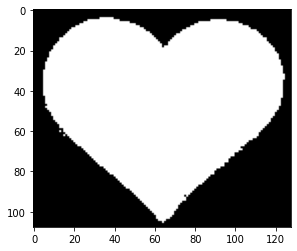

In [9]:
img_path = '/home/zetongqi/Downloads/heart.jpg'
#img_path = '/home/zetongqi/Pictures/Screenshot_20211115_210554.png'

img = cv2.imread(img_path)
grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, binary = cv2.threshold(grayimg, 15, 1, cv2.THRESH_BINARY)

plt.imshow(binary, cmap='gray')

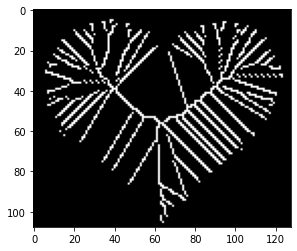

In [10]:
ret = skeletonization(binary, 'm')

plt.imshow(ret, cmap='gray')